## 2019 2nd ML month with KaKR


## 1. 데이터 탐색
### 1.1 문제 정의

집의 정보를 이용하여 회귀방식으로 가격을 예측하는 방식 

RMES를 이용하여 모델의 정확도를 평가함 



In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from scipy.stats import norm 
from sklearn.preprocessing import StandardScaler 
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

In [5]:
df_train = pd.read_csv('../input/train.csv')
df_test  = pd.read_csv('../input/test.csv')

In [ ]:
print(f"train.csv shape: {df_train.shape}")
print(f"test.csv shape: {df_test.shape}")

훈련과 평가 데이터의 크기는 약 15000과 6500으로 적은편</br>
비율은 약 5:2 로 균등하게 나누어진것을 확인</br>
변수의 갯수가 20개로 적은편</br>
위의 3가지 상황을 종합해 보았을 때 인과성이 있는 변수를 선택하여 학습을 하는 것이 모델성능에 관건이라고 추측 

### 1.2 변수설명 
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 0에서 4 사이의 부동산의 전망이 얼마나 좋은지에 대한지표
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15(한국) : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)</br>
  sqft_living15(영어) : 가장 가까운 이웃 15개에 대한 주거 공간의 평방 피트</br>
- sqft_lot15(한국) : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있을 수 있음)</br>
  sqft_lot15(한국) : 가장 가까운 이웃 15개 부지의 평방 피트</br>
  
  TODO: 집코드에 따른 부지의 평균
  waterfront 빼기
  

※ 20，21은 한국 공식문서와 영어공식문서의 설명이 달라 공용표기함

In [ ]:
df_train.head()

위의 값을 통해 아래와 같은 사실을 도출할 수 있다
- date의 경우 yyyymmddT000000의 형태로 T000000의 값은 무의미하다고 판단, 제거(slice)
- yr_renovated의 경우</br>
      0 : 재건축 안함
      0 이외의 양수 : 재건축을 시행한 년도
  이므로 0이상의 값이 있는 행은 yr_built의 값에 덮어쓰기를 해야한다고 판단 

### 1.3 변수 시각화 ( 목적변수 )

In [6]:
y = df_train['price']
y.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

이제부터 목적변수의 집합을 y라고 가정한다.</br>
이 목적변수에서 다음을 확인할 수 있다.
- 목적변수의 경우 표준편차가크고 왼쪽으로 분포가 치우친 것을 확인</br>
- 표준편차의 왜도와 첨도가 정규성에 만족하지 않은 사항을 확인</br>
※ 왜도, 첨도 통계량 검증방법을 사용했으며</br>
|왜도| < 2, |첨도| < 7 를 만족하지 못하면 데이터가 정규적이지 못하다고 판단가능</br>
아래의 그래프를 통해 시각적으로 확인가능하다

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y)

In [ ]:
print(f"Skewness: :{abs(y.skew()):.6f}")
print(f"Kurtosis: :{abs(y.kurt()):.6f}")

자세한 수치를 보면
- 왜도(skewness) : 기준치를 s, 현재 왜도의 절대값을 s_now_abs로 가정할시
                          3(|s|) < 4.290252(s_now_abs)
                   이므로 정규분포를 만족하지 못함
</br>
- 첨도(kurtosis) : 기준치를 k, 현재 첨도의 절대값을 k_now_abs로 가정할시
                          7(|k|) < 40.154919(k_now_abs)
                    이므로 정규분포를 만족하지 못함


이므로 일반화가 필요함</br>
※ 자세한 설명은 아래의 링크참고</br>
[왜도와 첨도의 의미](http://stat-university.tistory.com/entry/%EC%99%9C%EB%8F%84skew%EC%99%80-%EC%B2%A8%EB%8F%84kurtosis%EC%9D%98-%EC%9D%98%EB%AF%B8%EB%8A%94-%EB%AD%98%EA%B9%8C2%ED%8E%B8-%EC%B2%A8%EB%8F%84-%ED%8E%B8)

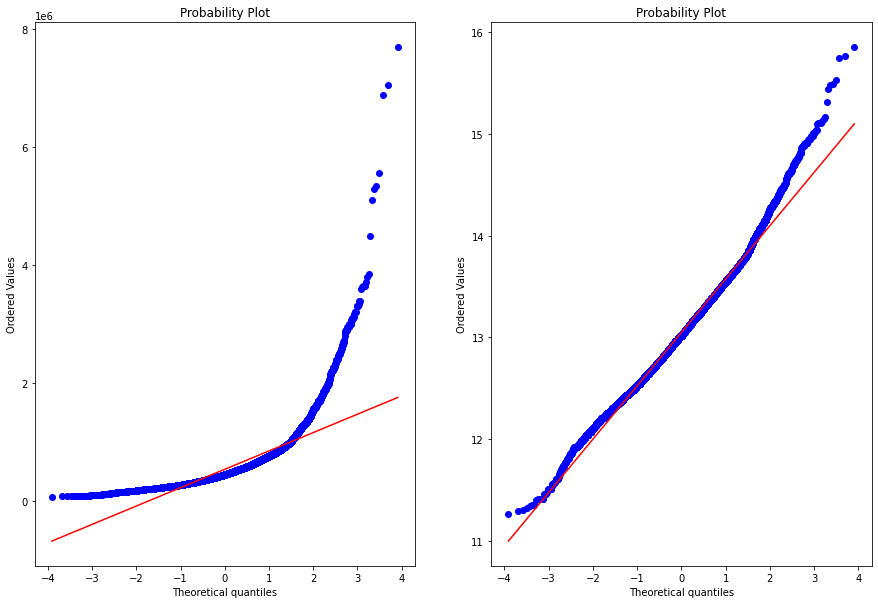

In [7]:
y_nomalize = np.log1p(y)
fig = plt.figure(figsize = (15,10))

# 정규화 안한 y의 값
fig.add_subplot(1,2,1)
res = stats.probplot(y, plot=plt)

# 정규화 한 y의 값
fig.add_subplot(1,2,2)
res = stats.probplot(y_nomalize, plot=plt)

log를 취해 정규화를 시키면 기존보다 더 정규성을 가지는 것을 확인할 수 있습니다. 

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y_nomalize)

In [8]:
print(f"Skewness: :{abs(y.skew()):.6f}")
print(f"Kurtosis: :{abs(y.kurt()):.6f}")

# 로그로 정규화를 할 시 정규분포를 만족하므로 값을 집어넣는다
df_train["price"] = y_nomalize
df_train.head()

Skewness: :4.290252
Kurtosis: :40.154919


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


평균값도 중앙에 가깝게 분포된 것을 확인할 수 있으며, 왜도와 첨도도 기준을 충족한 것을 확인할 수 있다.

### 1.3 변수시각화 ( 반응변수 )
- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용 

목적변수인 가격과 가장 상관관계가 높은 순서대로 스피어만 순위 상관관계를 본 히트맵을 도식화</br>


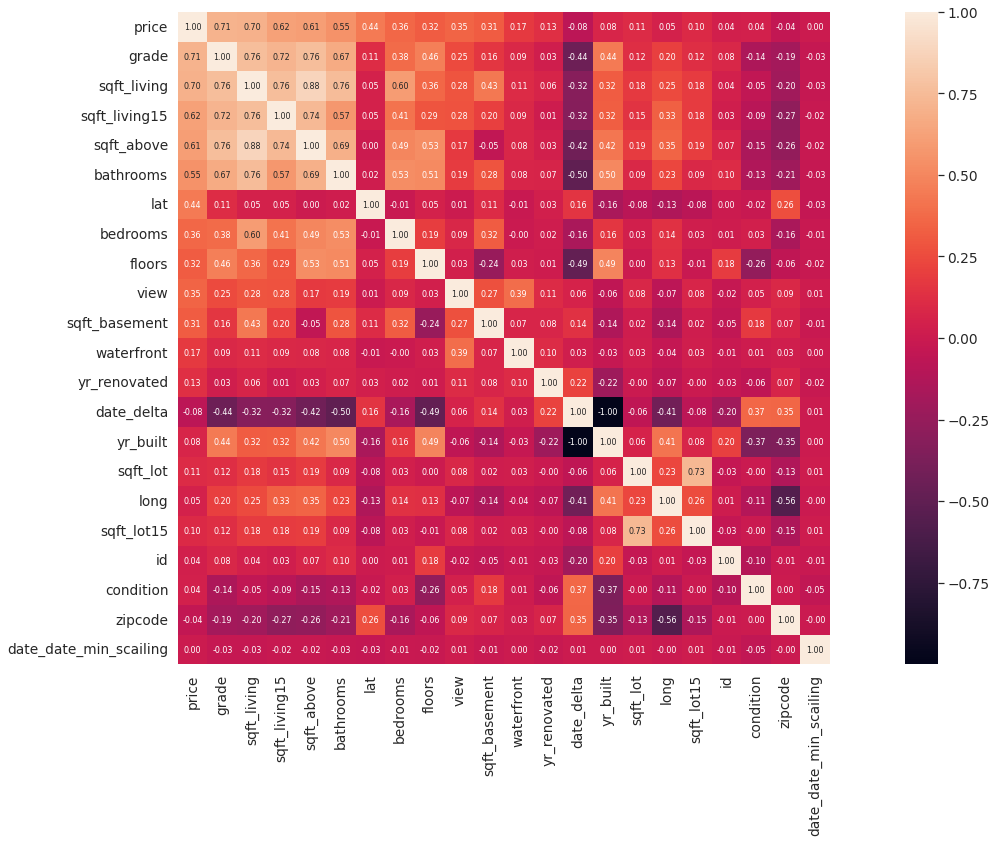

In [9]:
df_train["date_delta"] = (pd.to_datetime(df_train["date"].astype(str).str[:8]) - pd.to_datetime(df_train["yr_built"].astype(str), format="%Y")).dt.days
df_train["date_date"] = pd.to_datetime(df_train["date"].astype(str).str[:8])
df_train["date_date_min_scailing"] = (df_train["date_date"] - df_train["date_date"].min()).dt.days

corrmat = abs(df_train.corr(method='spearman'))
cols = corrmat.nlargest(len(df_train.columns)+1, 'price').index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(27, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

목적변수와 상관도가 높은 변수는 집의 등급, 주거공간의 크기, 전체 크기순이다. </br>
건축년도와 거래날짜와 건축년도의 사분은 똑같은 상관관계의 값을 가지고있다. </br>
판매날짜 - 판매날짜의 최소치를 일로변환해도 약한 음의 상관관계가 있다 </br>
위의 두 값은 불필요한 데이터로 간주됨</br>

대신 위의 표중 몇가지의 설명변수의 상관관계를 전처리를 통해 올려보면 아래와 같다.



In [11]:
renovated_idxs = df_train["yr_renovated"] > 0
df_train.loc[renovated_idxs, "yr_built"] = df_train.loc[renovated_idxs, "yr_renovated"]
df_train.loc[renovated_idxs, "yr_renovated"] = 1

리모델링의 상관관계는 0 혹은 0 이상의 이진데이터의 성향이 있다</br>
그러므로 0 이상을 1로 변환해주는 작업을 시행하였다.</br>
또한 리모델링과 건축이라는 행동을 동일시 생각하면 리모델링년도는 이전의 건축년도를 대체할 필요가 있다.</br>
위의 전처리를 통해 살펴보면 데이터의 적중확률이 같거나 올라간다

In [ ]:
corrmat = abs(df_train.corr(method='spearman'))
cols = corrmat.nlargest(len(df_train.columns)+1, 'price').index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(27, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

가장 상관관계가 높은 반응변수인 등급부터 분포도를 살펴보면 6~10까지가 사분위를 벗어나는 값이 많다</br>
이는 추가적으로 전처리가 필요하다고 판단된다.</br>
또한 11등급의 하나의 집이 비정상적으로 가격이 높은것을 확인할 수 있다


In [ ]:
print(f"Skewness: :{abs(df_train['sqft_living'].skew()):.6f}")
print(f"Kurtosis: :{abs(df_train['sqft_living'].kurt()):.6f}")

data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

그 다음으로 상관도가 높은 주거공간의 크기를 살펴보면</br>
전반적으로 선형성을 보이지만 가격이 14.5 ~ 16사이, 주거공간이 12000 ~ 14000사이의 값들을 이상치로 판단</br>

In [ ]:
print(f"Skewness: :{abs(df_train['sqft_living15'].skew()):.6f}")
print(f"Kurtosis: :{abs(df_train['sqft_living15'].kurt()):.6f}")

data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

corrmat = abs(df_train.corr(method='spearman'))
cols = corrmat.nlargest(len(df_train.columns)+1, 'price').index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(27, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

sqft_living15의 경우 영어원문의 해석으로 하면 주위의 15명의 이웃의 생활공간 크기의 분포이며</br>
대채로 한 지역에 건물들은 서로 비슷한 가격과 평수를 형성하고 있기때문에 상관관계는 높으나</br>
sqft_living보다 편차가 크다</br>
2000 ~ 5000서 간간히 이상치가 보인다

In [ ]:
print(f"Skewness: :{abs(df_train['sqft_basement'].skew()):.6f}")
print(f"Kurtosis: :{abs(df_train['sqft_basement'].kurt()):.6f}")

data = pd.concat([df_train['price'], df_train['sqft_basement']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_basement', y="price", data=data)

sqft_living보다 편차가 크다</br>
지하실은 없는 집도 존재하기 때문에 부지가 0이여도 가격이 다양하다. </br>
하지만 다른 값과 혼합하면 사용할 수 있을 듯 하다.

In [ ]:
sqft_all = df_train['sqft_basement'] + df_train['sqft_above']
sqft_all.name = "sqft_all"

print(f"Skewness: :{abs(sqft_all.skew()):.6f}")
print(f"Kurtosis: :{abs(sqft_all.kurt()):.6f}")

data = pd.concat([df_train['price'], sqft_all], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_all', y="price", data=data)

이로써 부지의 총 면적은 가격과 강한 상관관계가 있다는 사실을 알 수 있다.</br>
하지만 약 8000부터 일부 상관관계가 약한 몇개의 집이 보인다.</br>
해당 값을 히트맵으로 확인해보면

In [ ]:
df_train["sqft_all"] = sqft_all

corrmat = abs(df_train.corr(method='spearman'))
cols = corrmat.nlargest(len(df_train.columns)+1, 'price').index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(27, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.4f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

주거공간과 똑같은 상관관계를 가지고 있다.</br>
또한 첨도와 왜도도 똑같다.</br>
그렇다면 주거공간 이외의 부지는 가격에 영향을 안미친다는 결론이 나온다.

In [ ]:
sqft_ex_basement = df_train['sqft_living'] - df_train['sqft_basement']
sqft_ex_basement.name = "sqft_ex_basement"

print(f"Skewness: :{abs(sqft_ex_basement.skew()):.6f}")
print(f"Kurtosis: :{abs(sqft_ex_basement.kurt()):.6f}")

data = pd.concat([df_train['price'], sqft_ex_basement], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_ex_basement', y="price", data=data)

In [ ]:
df_train["sqft_ex_basement"] = sqft_ex_basement

corrmat = abs(df_train.corr(method='spearman'))
cols = corrmat.nlargest(len(df_train.columns)+1, 'price').index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(27, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

지하공간을 뺀 나머지 생활공간만으로 적중확률을 구했더니 다른 면적과 가격에 관한 상관관계보다 더 떨어진 값이 나왔다.</br>
그렇다면 위의 상관관계를 가중치로 두고 새로운 값을 아래와 같이 구하였다.

In [ ]:
sqft_living_weight = df_train['sqft_ex_basement'] + df_train['sqft_basement'] * 0.5
sqft_living_weight.name = "sqft_living_weight"
print(f"Skewness: :{abs(sqft_living_weight.skew()):.6f}")
print(f"Kurtosis: :{abs(sqft_living_weight.kurt()):.6f}")

data = pd.concat([df_train['price'], sqft_living_weight], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living_weight', y="price", data=data)

In [ ]:
df_train["sqft_living_weight"] = sqft_living_weight

corrmat = abs(df_train.corr(method='spearman'))
cols = corrmat.nlargest(len(df_train.columns)+1, 'price').index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(27, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

가중치를 두었음에도 여전히 확률은 생활공간 총면적대비 가격에 못미치는 것을 확인가능하다.</br>

In [ ]:
sqft_per_floor = df_train['sqft_living'] / df_train['floors']
sqft_per_floor.name = "sqft_per_floor"
print(f"Skewness: :{abs(sqft_per_floor.skew()):.6f}")
print(f"Kurtosis: :{abs(sqft_per_floor.kurt()):.6f}")

data = pd.concat([df_train['price'], sqft_per_floor], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_per_floor', y="price", data=data)

In [ ]:
df_train["sqft_per_floor"] = sqft_per_floor

corrmat = abs(df_train.corr(method='spearman'))
cols = corrmat.nlargest(len(df_train.columns)+1, 'price').index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(27, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

층수당 면적도 상관관계가 떨어진다.</br>
이는 층수가 많은 건물이 단지 생활공간이 대체로 넓기때문에 상관관계있는것 뿐이다.</br>
그러므로 면적에 대한 변수에서만 별 가공없이 생활공간면적 하나만 사용하는 것으로 결론지었다.

In [ ]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

bathrooms은 0.25당 시설 하나로 취급된다.
- 0.5 : 세면대, 화장실 
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조 

In [ ]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

방수에 따른 가격이다.</br>
생각보다 사분위를 벗어나는 값이 많다.

### 1.4 결측치 

In [12]:
df_train = pd.read_csv('../input/train.csv')
df_test  = pd.read_csv('../input/test.csv')

print(f"df_train:\n{df_train.notna().all()}\n")
print(f"df_test:\n{df_test.notna().all()}\n")

df_train:
id               True
date             True
price            True
bedrooms         True
bathrooms        True
sqft_living      True
sqft_lot         True
floors           True
waterfront       True
view             True
condition        True
grade            True
sqft_above       True
sqft_basement    True
yr_built         True
yr_renovated     True
zipcode          True
lat              True
long             True
sqft_living15    True
sqft_lot15       True
dtype: bool

df_test:
id               True
date             True
bedrooms         True
bathrooms        True
sqft_living      True
sqft_lot         True
floors           True
waterfront       True
view             True
condition        True
grade            True
sqft_above       True
sqft_basement    True
yr_built         True
yr_renovated     True
zipcode          True
lat              True
long             True
sqft_living15    True
sqft_lot15       True
dtype: bool



데이터에는 결측치가 없는 상황을 확인. 

## 2. 데이터 전처리 
### 2.1 이상치 제거 
아래의 변수들에 대해 이상치를 제거</br>
- sqft_living
- grade
- bedrooms 

#### 2.1.1 sqft_living

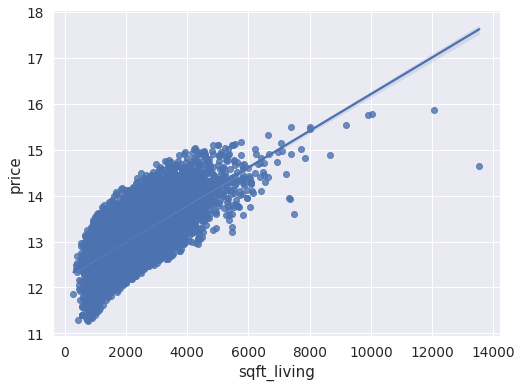

In [13]:
data = pd.concat([np.log1p(df_train['price']), df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [14]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,2280000.0,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


위의 값을 봤을 때, 다른값들에 비해 sqft_living만 비정상적으로 꽤 큰 것을 알 수 있습니다. 따라서 이 값은 이상치로 보고 제거하도록 하겠습니다. 

In [15]:
df_train = df_train.loc[df_train['sqft_living'] < 13001]

#### 2.1.2 grade

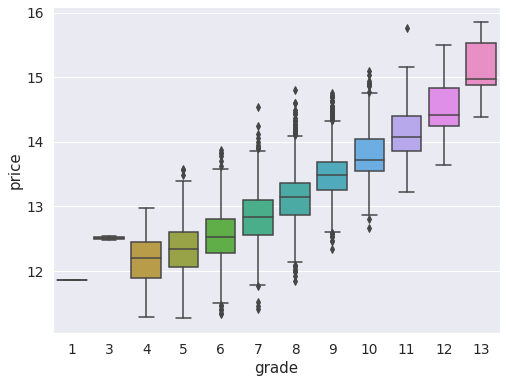

In [16]:
data = pd.concat([np.log1p(df_train['price']), df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [17]:
df_train.loc[(np.log1p(df_train['price'])>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,7062500.0,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [18]:
df_train = df_train.loc[(np.log1p(df_train['price'])<15.5) & (df_train['grade'] != 11)]

위의 3값 모두 특별한 이유가 없이 가격이 높아 보이므로 이상치로 규정하고 제거하도록 하겠습니다. 

### 2.2 정규화 

In [19]:
renovated_idxs = df_train["yr_renovated"] > 0
df_train.loc[renovated_idxs, "yr_built"] = df_train.loc[renovated_idxs, "yr_renovated"]
df_train.loc[renovated_idxs, "yr_renovated"] = 1

renovated_idxs = df_test["yr_renovated"] > 0
df_test.loc[renovated_idxs, "yr_built"] = df_test.loc[renovated_idxs, "yr_renovated"]
df_test.loc[renovated_idxs, "yr_renovated"] = 1

In [22]:
df_train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### 2.3 학습

In [20]:
df_train = df_train[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'lat', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated']]
df_test = df_test[['bedrooms', 'bathrooms', 'sqft_living', 'lat', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated']]

df_train = df_train.loc[df_train['sqft_living'] < 13001]
df_train = df_train.loc[(np.log1p(df_train['price'])<15.5) & (df_train['grade'] != 11)]

df_train["price"] = np.log1p(df_train["price"])

param_grid = {
    'n_estimators': [100, 300,500],
    'max_depth': [10, 20, 50],
    'learning_rate': [0.1, 0.01]
}

model_lgb = LGBMRegressor(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=random_state)
model_lgb.fit(df_train, y)
y_pred_lgbm = model_lgb.predict(df_test)
y_pred_lgbm_ck = model_lgb.predict(df_train)

# XGBRegressor
model_xgb = XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=300, random_state=random_state)
model_xgb.fit(df_train, y)
y_pred_xgbm = model_xgb.predict(df_test)
y_pred_xgbm_ck = model_xgb.predict(df_train)

# prediction = y_pred_xgbm
# prediction_ck = y_pred_xgbm_ck

# blending
prediction = (y_pred_lgbm+y_pred_xgbm)/2
prediction_ck = (y_pred_lgbm_ck+y_pred_xgbm_ck)/2

# check!
print(rmse(y,y_pred_lgbm_ck))
print(rmse(y,y_pred_xgbm_ck))

print(rmse(y,prediction_ck))

## 3. 변수 생성

In [21]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
prediction = np.expm1(prediction)

# summission 파일 불러오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

#예측값 기록하기
submission['price'] = prediction
submission.head()

# 저장하기
submission_csv_path = '{}/submission_{}.csv'.format(data_dir,'0922_2201')
submission.to_csv(submission_csv_path, index=False)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}
         
#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

In [ ]:
prediction = np.expm1(prediction)

data_dir = '../input'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

#예측값 기록하기
submission['price'] = prediction
submission.head()

# 저장하기
submission_csv_path = '{}/submission_{}.csv'.format(data_dir,'0922_2201')
submission.to_csv(submission_csv_path, index=False)